# Coalescence in a fixed-size population with fixed division time

This is a simple simulation of cell division. Each cell divides when it reaches a fixed age, replacing itself and a random cell that didn't divide with its two offspring. Over time, the population will coalesce, meaning all cells have a common ancestor.

This code works as follows:
1. The oldest cell(s) are marked for division. A matching number of cells are marked for death.
2. All cells marked for division or death are recorded in the census, which records a unique ID number, a parent ID number, an oldest ancestor ID number, a birth time, and a death time.
3. The current population is updated: Everyone ages by a - age_max, except the new cells which have an age of 0.
4. This process repeats.

The output of the code is a `pandas` DataFrame object.

The cell below imports the necessary packages and defines the functions `run_simulation` and `population_at_time_t`. The latter is for convenience (and shows one way to select a subset of a DataFrame)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

def run_simulation(N, T, a):
    """Run the simulation of 'divide at age a' cells with a fixed population.
    
    Parameters:
        N: Population size
        T: Stop time for the whole simulation
        a: division age
        
    Returns:
        censuse: A `pandas` DataFrame with columns "ID", "Parent", "Ancestor", "Birth", "Death" """
    # the current state: every cell has an age, an id number, a parent, and an oldest ancestor
    curr_age = np.random.rand(N)
    curr_birth = np.zeros(N)
    curr_id = np.arange(N)
    curr_parent = np.arange(N)
    curr_ancestor = np.arange(N)

    # history will be kept as lists with things continually appended
    id_numbers = []
    parents = []
    oldest_ancestors = []
    birth_times = []
    death_times = []

    t = 0
    next_id_to_use = N
    # print(f"{t=:8.3f}  Population:", curr_id)
    while t < T:
        oldest = curr_age.max()
        dt = a - oldest
        t += dt  # current time moves forward to the next division event
        
        # get the indices of cells who divide
        divider_indices = np.argwhere(curr_age == curr_age.max()).ravel()  # np.argmax() only grabs the first max value
    #     death_indices = np.random.choice(np.setdiff1d(np.arange(N), divider_indices),  # choose random indices
    #                                      size=divider_indices.shape,                   # which are not those
    #                                      replace=False)                                # where a birth just happened
        possible_deaths = np.setdiff1d(np.arange(N), divider_indices)
        death_indices = np.random.choice(possible_deaths,
                                         size=min(len(divider_indices), len(possible_deaths)),
                                         replace=False)
        dividers = curr_id[divider_indices]  # the actual ID number of those that divide
        deaths = curr_id[death_indices]  # the actual ID number of those that die without dividing

    #     print(f"          {dividers=}, {deaths=}")

        # record the life of the cells that just died (either by dividing or dying)
        for idx in chain(divider_indices, death_indices):
            id_numbers.append(curr_id[idx])
            parents.append(curr_parent[idx])
            oldest_ancestors.append(curr_ancestor[idx])
            birth_times.append(curr_birth[idx])
            death_times.append(t)

        # now move time forward for everyone else
        curr_age = curr_age + dt  # everyone gets older
        curr_age[divider_indices] = 0  # the indices corresponding to cells that divided are reset
        curr_age[death_indices] = 0  # as do ages of cells that died
        curr_birth[divider_indices] = t
        curr_birth[death_indices] = t
        for div, div_idx, death_idx, in zip(dividers, divider_indices, death_indices):
            curr_parent[div_idx] = div
            curr_parent[death_idx] = div
            curr_ancestor[death_idx] = curr_ancestor[div_idx]
            curr_id[div_idx] = next_id_to_use
            next_id_to_use += 1
            curr_id[death_idx] = next_id_to_use
            next_id_to_use += 1

    #     print(f"{t=:8.3f} Population:", curr_id)
    #     print(f"{t=:8.3} Population:")
    #     print(f"        {curr_id}")
    #     print(f"        {curr_age}")

    census = pd.DataFrame({"ID": id_numbers,
                           "Parent": parents,
                           "Ancestor": oldest_ancestors,
                           "Birth": birth_times,
                           "Death": death_times})
    return census

def population_at_time_t(census, t):
    """Return just the cells that are alive at time t"""
    return census[(census.Birth <= t) & (census.Death > t)]

The code below will give you an idea how the simulation time scales with the population. Note the last one might take a while!

In [84]:
N, T, a = 17, 34, 1.0  # population size, length of simulation time, division age

print(f"Simulation with {N} cells")
%timeit run_simulation(N, T, a)

N, T, a = 1700, 34, 1.0  # population size, length of simulation time, division age

print(f"Simulation with {N} cells")
%timeit run_simulation(N, T, a)

N, T, a = 10000, 34, 1.0  # population size, length of simulation time, division age

print(f"Simulation with {N} cells")
%timeit run_simulation(N, T, a)

Simulation with 17 cells
7.35 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Simulation with 1700 cells
1.45 s ± 33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Simulation with 10000 cells
22.7 s ± 1.48 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Example simulation

In [97]:
N, T, a = 17, 34, 1.0  # population size, length of simulation time, division age
census = run_simulation(N, T, a)
census["age"] = census.Death - census.Birth
census

,ID,Parent,Ancestor,Birth,Death,age
0,2,2,2,0.000000,0.007884,0.007884
1,16,16,16,0.000000,0.007884,0.007884
2,7,7,7,0.000000,0.009601,0.009601
3,11,11,11,0.000000,0.009601,0.009601
4,9,9,9,0.000000,0.393936,0.393936
...,...,...,...,...,...,...
608,88,65,14,33.508168,34.508168,1.000000
609,93,68,14,33.508168,34.508168,1.000000
610,95,71,14,33.508168,34.508168,1.000000
611,108,87,14,33.508168,34.508168,1.000000


Who's alive at time $t = 2.1$?

In [83]:
population_at_time_t(census, 2.1).sort_values("Ancestor")

,ID,Parent,Ancestor,Birth,Death
60,53,28,0,1.401932,2.401932
59,52,27,0,1.401932,2.401932
58,54,28,0,1.401932,2.401932
56,49,26,2,1.328407,2.328407
54,47,23,5,1.290737,2.290737
55,62,40,6,1.991988,2.290737
70,61,40,6,1.991988,2.991988
52,46,21,10,1.202358,2.202358
68,59,34,11,1.831659,2.831659
49,60,34,11,1.831659,2.167180


Let's see how quickly this population coalesces

Text(0, 0.5, 'Number')

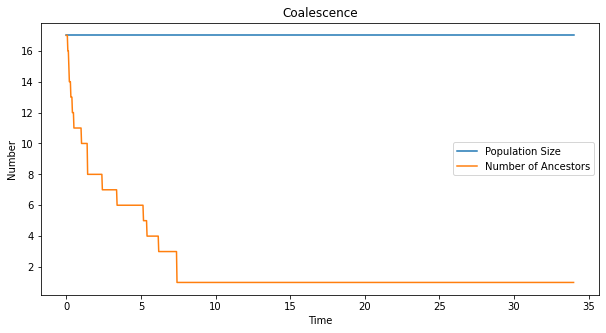

In [82]:
ts = np.linspace(0, T, 1000)
pop_size = [population_at_time_t(census, t).shape[0] for t in ts]
n_ancestors = [population_at_time_t(census, t)["Ancestor"].unique().shape[0] for t in ts]

plt.figure(figsize=(10,5))
plt.plot(ts, pop_size, label="Population Size")
plt.plot(ts, n_ancestors, label="Number of Ancestors")
plt.legend()
plt.title("Coalescence")
plt.xlabel("Time")
plt.ylabel("Number")

I personally hate Python, but I have learned to love Pandas, because it can do things like this:

In [72]:
lineages = census.groupby("Ancestor").agg({"Birth":"min", "Death":"max"})
lineages["Lifespan"] = lineages.Death - lineages.Birth
lineages

,Birth,Death,Lifespan
Ancestor,,,
0,0.0,34.401932,34.401932
1,0.0,1.401932,1.401932
2,0.0,6.167180,6.167180
3,0.0,0.505151,0.505151
4,0.0,0.079223,0.079223
5,0.0,5.167180,5.167180
6,0.0,3.401932,3.401932
7,0.0,0.991988,0.991988
8,0.0,0.401932,0.401932


This shows you how many cells were born at each time.

,ID
Birth,
0.000000,17
0.079223,2
0.167180,2
0.202358,2
0.290737,2
...,...
29.401932,17
30.401932,17
31.401932,17


Text(0, 0.5, '# Births')

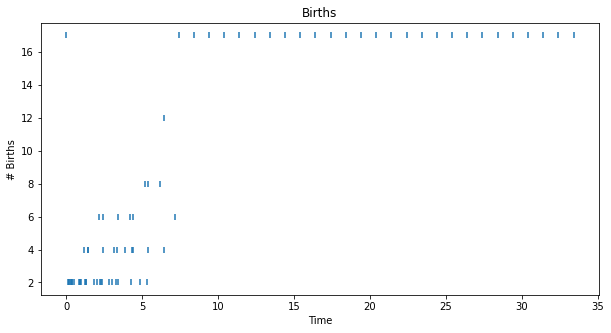

In [79]:
birth_counts = census.groupby("Birth").agg({"ID":"count"})
display(birth_counts)
plt.figure(figsize=(10,5))
plt.scatter(birth_counts.index, birth_counts.ID, marker="|")
plt.title("Births")
plt.xlabel("Time")
plt.ylabel("# Births")